6 March 2024
# <center>Lab 8 Assignment - CS 4315<center>
<center>Doug Andrade</center>

#### 1. Load 'armada.csv' and convert all categorical columns to either binary or one-hot vectors, as requested previously and excluding 'Battle' and 'Portuguese Outcome'.

In [1]:
#Import Python modules
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read-in the csv file as a Pandas data frame
csv_file = 'armada.csv'
armada_df = pd.read_csv(filepath_or_buffer = csv_file)

# Drop the specified columns
armada_train_df = armada_df.drop(columns = ['Battle', 'Portuguese Outcome'], 
                                 axis = 1)

armada_train_df.head(3)

,Year,Portuguese Ships,Dutch Ships,English Ships,Ratio of Portuguese Ships to Dutch/British Ships,Spanish Involvement
0,1601,6,3,0,2.000,No
1,1606,14,11,0,1.273,No
2,1606,6,9,0,0.667,No


In [3]:
# List all categorical columns
categorical_col_list = [col for col in armada_train_df.columns if armada_train_df[col].dtype == 'object']

# Loop through categorical columns
for col in categorical_col_list:
    # Check of binary columns (two categories)
    if armada_train_df[col].nunique() < 3:
        # Create the new binary column name
        binary_col_name = col + ' Binary'
        # Build out the new binary column, without replacing the orginal
        armada_train_df[binary_col_name] = armada_train_df[col].replace(to_replace = {'No': 0, 'Yes': 1})
    else:
        # concatenate the one-hot encoded columns to the original dataframe, setting drop_first to False
        armada_train_df = pd.concat(objs = [armada_train_df, 
                                            pd.get_dummies(data = armada_train_df[col],
                                                           prefix = col,
                                                           drop_first = False)],
                                    axis = 1)
        
armada_train_df.head(3)

,Year,Portuguese Ships,Dutch Ships,English Ships,Ratio of Portuguese Ships to Dutch/British Ships,Spanish Involvement,Spanish Involvement Binary
0,1601,6,3,0,2.000,No,0
1,1606,14,11,0,1.273,No,0
2,1606,6,9,0,0.667,No,0


#### 2. Z-Score all of the numerical columns and the binary and one-hot columns created in 1.

In [4]:
# Using list comprehension and conditional statements, create a list of all the numeric column names
numeric_col_list = [col for col in armada_train_df.columns if armada_train_df[col].dtype != 'object']

armada_zscore = armada_train_df.copy()

# Iterate over columns that exist in the "numeric_col_list"
for col in numeric_col_list:
    # Create a new column name for the cooresponding columns Z-Score
    zscored_col_name = col + ' Z-Score'
    # Insert the new Z-Score column next to the parent column by adding one to the parent's column position
    armada_zscore.insert(loc = armada_zscore.columns.get_loc(col) + 1,
                         column = zscored_col_name,
                         value = (armada_zscore[col] - armada_zscore[col].mean()) / armada_zscore[col].std())

armada_zscore_df = armada_zscore.drop(labels = ['Year',
                                                'Portuguese Ships',
                                                'Dutch Ships',
                                                'English Ships',
                                                'Ratio of Portuguese Ships to Dutch/British Ships',
                                                'Spanish Involvement',
                                                'Spanish Involvement Binary'], 
                                      axis = 1,
                                      inplace = False)

armada_zscore_df.head(3)

,Year Z-Score,Portuguese Ships Z-Score,Dutch Ships Z-Score,English Ships Z-Score,Ratio of Portuguese Ships to Dutch/British Ships Z-Score,Spanish Involvement Binary Z-Score
0,-1.560039,-0.448594,-0.468067,-0.301249,0.904955,-0.914174
1,-1.275286,0.053831,-0.109002,-0.301249,0.121838,-0.914174
2,-1.275286,-0.448594,-0.198768,-0.301249,-0.530939,-0.914174


#### 3. Perform PCA  on the z-scored data using the best number of components per an elbow plot. 

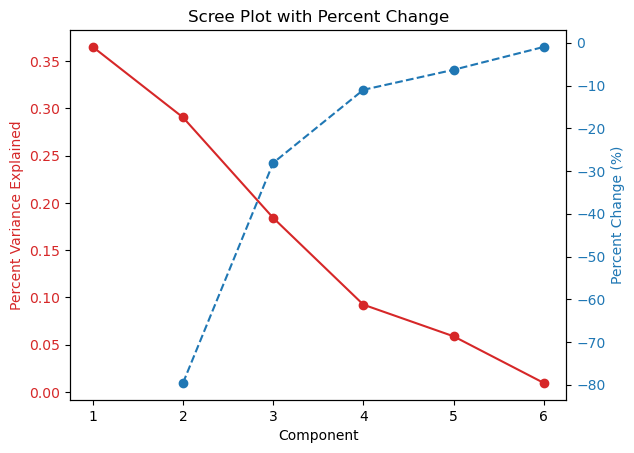

In [5]:
armada_z_array = armada_zscore_df.to_numpy()

#Create a principle component analysis (PCA) model that using all components
pca = PCA()
armada_z_array_pcafit = pca.fit_transform(armada_z_array)

# Create an array of components, beginning with '1'
pc_values = np.arange(start = 0, stop = pca.n_components_) + 1

# Calculate the cumulative percentage of explained variance
cumulative_variance = np.cumsum(a = pca.explained_variance_ratio_,
                                axis = None)

# Calculate the percent change in explained variance
percent_chg_scree = [100 * (cumulative_variance[i - 1] - cumulative_variance[i]) / cumulative_variance[i - 1] if i > 0 else 0 for i in range(len(cumulative_variance))]

fig1, ax1 = plt.subplots()

# Scree plot (in red)
color = 'tab:red'
ax1.set_xlabel(xlabel = 'Component')
ax1.set_ylabel(ylabel = 'Percent Variance Explained',
               color = color)
ax1.plot(pc_values, pca.explained_variance_ratio_, 
         marker = 'o', 
         color = color)
ax1.tick_params(axis = 'y', 
                labelcolor = color)

# Percent change for each component - to provide an additional metric to select number of components, using a 'twin axis' (blue)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(ylabel = 'Percent Change (%)', 
               color = color)

# Plot the percent change, ignoring the 1st point (not relevant)
ax2.plot(pc_values[1:], percent_chg_scree[1:], 
         marker = 'o', 
         linestyle = '--', 
         color = color)
ax2.tick_params(axis = 'y', 
                labelcolor = color)

plt.title(label = 'Scree Plot with Percent Change')
plt.show()

In [6]:
#Create a principle component analysis (PCA) model - I selected 4 based on the scree & percent change plot
pca_3 = PCA(n_components = 3)

#Train the PCA model on the data array
pca_trained_3 = pca_3.fit_transform(X = armada_z_array)

#### 4. Cluster the PCA transformed data using k-means and the best k per an inertia plot.

In [7]:
#Calculate the intertias for different values of k
inertias = []
ks = []
for i in range(10):
    k = i + 1
    ks.append(k)
    #print('K='+str(k))
    kmeans = KMeans(n_clusters = k, 
                    n_init = 10)
    kmeans.fit(X = pca_trained_3)
    #print('inertia=' + str(kmeans.inertia_))
    inertias.append(kmeans.inertia_)

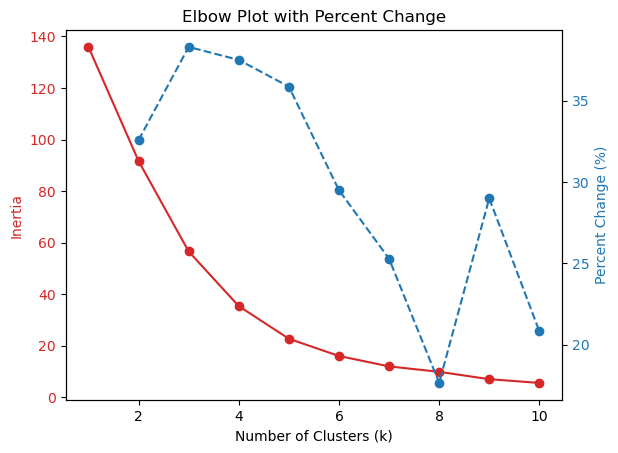

In [8]:
# Calculate percent change in inertia
percent_change = [100 * (inertias[i - 1] - inertias[i]) / inertias[i - 1] if i > 0 else 0 for i in range(len(inertias))]

# Plotting the elbow plot with percent change
fig2, ax2 = plt.subplots()

color = 'tab:red'
ax2.set_xlabel(xlabel = 'Number of Clusters (k)')
ax2.set_ylabel(ylabel = 'Inertia', 
               color = color)
ax2.plot(ks, inertias, 
         marker = 'o', 
         color = color)
ax2.tick_params(axis = 'y', 
                labelcolor = color)

ax3 = ax2.twinx()
color = 'tab:blue'
ax3.set_ylabel(ylabel = 'Percent Change (%)', 
               color = color)

# Plot the percent change, ignoring the 1st point (not relevant)
ax3.plot(ks[1:], percent_change[1:],
         marker = 'o', 
         linestyle = '--', 
         color = color)
ax3.tick_params(axis = 'y', 
                labelcolor = color)

plt.title('Elbow Plot with Percent Change')
plt.show()

In [9]:
# Perform kMeans - I selected k = 4 based on elbow & percent change plot
kMeans_4 = KMeans(n_clusters = 4, 
                  n_init = 10)

kMeans_4.fit_predict(X = pca_trained_3)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1], dtype=int32)

#### 5. Cluster the PCA transformed data using a Gaussian mixture model and the best number of Gaussians per BIC, to a maximum of five Gaussians.

In [10]:
# 5. Cluster the PCA transformed data using a Gaussian mixture model and the best number of Gaussians per BIC, to a maximum of five Gaussians.
#Calculate the BICs for different values of k
bics = []
ks = []
for i in range(10):
    k = i + 1
    ks.append(k)
    print('K=' + str(k))
    gmm = GaussianMixture(n_components = k, 
                          random_state = 42)
    gmm.fit(X = pca_trained_3)
    bic = gmm.bic(X = pca_trained_3)
    print('bic=' + str(bic))
    bics.append(bic)

K=1
bic=305.5653847899737
K=2
bic=268.8592791195841
K=3
bic=254.32720118858646
K=4
bic=234.5756429433151
K=5
bic=222.32551848879862
K=6
bic=224.37879924107307
K=7
bic=183.1650592316118
K=8
bic=189.52292645616575
K=9
bic=179.52977590788228
K=10
bic=161.35763936749052


In [11]:
# Select 5 Gaussians, per instructions and its the lowest BIC before increasing
gmm_5 = GaussianMixture(n_components = 5)

In [12]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(a = covariance)
        angle = np.degrees(x = np.arctan2(x = U[1, 0], 
                                          y = U[0, 0]))
        width, height = 2 * np.sqrt(x = s)
    
    elif covariance.shape[0] == 2:  # If covariance is a 2D array with shape (2, n)
        width, height = 2 * np.sqrt(np.diag(v = covariance))
        angle = 0
    
    else:
        width, height = 2 * np.sqrt(np.diag(v = covariance[:2, :2]))
        angle = 0
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy = position,
                             width = nsig * width, 
                             height = nsig * height,
                             angle = angle, 
                             **kwargs))

def plot_gmm(gmm, X, 
             label = True, 
             ax = None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(x = X[:, 0], 
                   y = X[:, 1], 
                   c = labels, 
                   s = 40, 
                   cmap = 'viridis', 
                   zorder = 2)
    else:
        ax.scatter(x = X[:, 0],
                   y = X[:, 1], 
                   s = 40, 
                   zorder = 2)
    
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(position = pos, 
                     covariance = covar, 
                     alpha = w * w_factor)

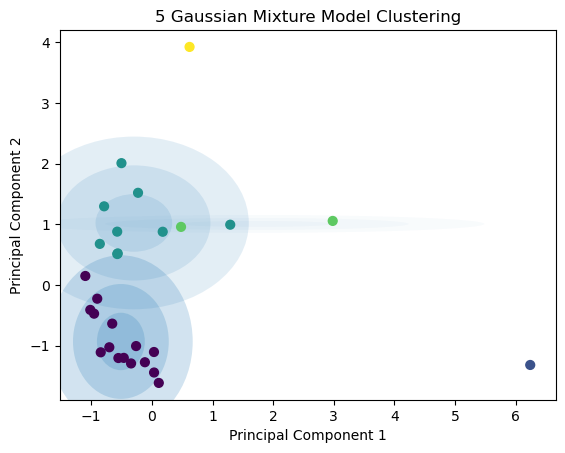

In [13]:
plot_gmm(gmm_5, pca_trained_3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('5 Gaussian Mixture Model Clustering')
plt.show()